In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Step 2: Load Dataset
df = pd.read_csv("Garmin_run_data.csv")
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530,0:43:55,141,160,176,182,7:19,6:20,169,173,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587,0:47:04,144,160,172,182,7:14,6:35,183,187,1.29,03:32.7,7
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392,0:40:29,128,151,170,180,8:05,5:49,124,124,1.17,00:04.1,6
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633,0:52:55,142,157,172,180,7:33,5:00,215,219,1.24,00:05.1,8
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419,0:41:35,129,143,170,178,8:01,6:48,76,80,1.18,01:27.1,6


In [3]:
# Step 3: Convert time (e.g., 0:43:55 or 03:32.7) to total minutes
def convert_to_minutes(time_str):
    try:
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:
            return parts[0]*60 + parts[1] + parts[2]/60
        elif len(parts) == 2:
            return parts[0] + parts[1]/60
    except:
        return np.nan

df['Time (min)'] = df['Time'].apply(convert_to_minutes)

In [4]:
# Step 4: Convert Avg Pace (e.g., 7:19) to seconds per km
def pace_to_seconds(pace_str):
    try:
        minutes, seconds = map(int, pace_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

df['Avg Pace (sec)'] = df['Avg Pace'].apply(pace_to_seconds)

In [5]:
# Step 5: Clean numeric columns
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
df['Avg HR'] = pd.to_numeric(df['Avg HR'], errors='coerce')
df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')

In [6]:
# Step 6: Create synthetic hydration target using simple sports science logic
df['Hydration Need (mL/hr)'] = 400 + 0.5 * df['Calories'] + 0.2 * df['Avg HR']

In [7]:
# Step 7: Drop rows with missing required data
features = ['Distance', 'Avg HR', 'Time (min)', 'Avg Pace (sec)']
df = df.dropna(subset=features + ['Hydration Need (mL/hr)'])

In [8]:
# Step 8: Train a Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(df[features], df['Hydration Need (mL/hr)'])

# Predict on the same data for now
df['Predicted Hydration Need (mL/hr)'] = model.predict(df[features])

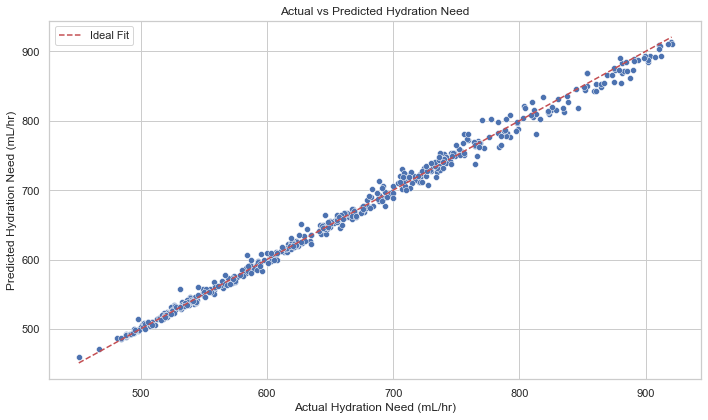

In [9]:
# Step 9: Plot Actual vs Predicted Hydration Need
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Hydration Need (mL/hr)'], y=df['Predicted Hydration Need (mL/hr)'])
plt.plot([df['Hydration Need (mL/hr)'].min(), df['Hydration Need (mL/hr)'].max()],
         [df['Hydration Need (mL/hr)'].min(), df['Hydration Need (mL/hr)'].max()],
         'r--', label='Ideal Fit')
plt.xlabel('Actual Hydration Need (mL/hr)')
plt.ylabel('Predicted Hydration Need (mL/hr)')
plt.title('Actual vs Predicted Hydration Need')
plt.legend()
plt.tight_layout()
plt.show()

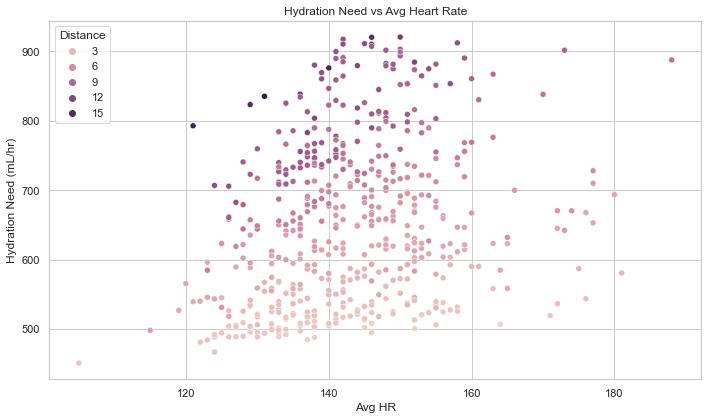

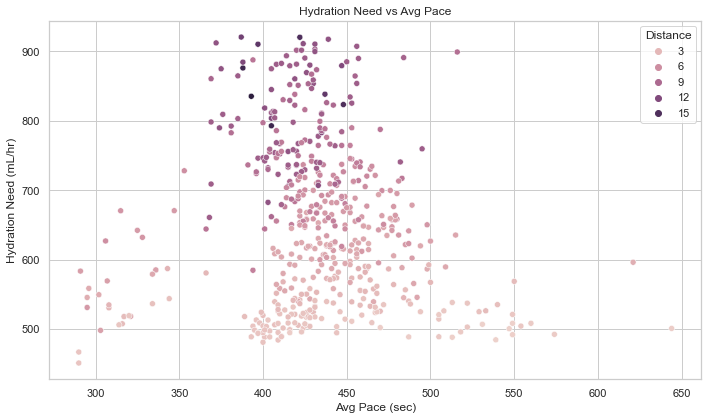

In [10]:
# Step 10: Hydration Need vs Heart Rate and Pace
# (A) vs Avg HR
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg HR', y='Hydration Need (mL/hr)', hue='Distance', data=df)
plt.title('Hydration Need vs Avg Heart Rate')
plt.tight_layout()
plt.show()

# (B) vs Avg Pace
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg Pace (sec)', y='Hydration Need (mL/hr)', hue='Distance', data=df)
plt.title('Hydration Need vs Avg Pace')
plt.tight_layout()
plt.show()

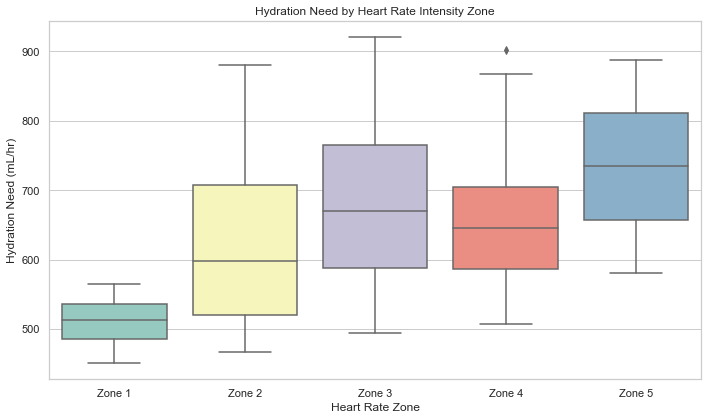

In [11]:
# Step 11: Visualize Hydration Need by Heart Rate Zone (Intensity)
df['HR Zone'] = pd.cut(df['Avg HR'], bins=[0, 120, 140, 160, 180, 200],
                       labels=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='HR Zone', y='Hydration Need (mL/hr)', data=df, palette='Set3')
plt.title('Hydration Need by Heart Rate Intensity Zone')
plt.xlabel('Heart Rate Zone')
plt.ylabel('Hydration Need (mL/hr)')
plt.tight_layout()
plt.show()